<a href="https://colab.research.google.com/github/BalchandraJha/StackNet/blob/master/Earthquake_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install kaggle
!pip install kaggle
#install numpy
!pip install numpy==1.15.0
#install boosting lib(catboost)
!pip install catboost


    100% |████████████████████████████████| 55.5MB 622kB/s 


In [0]:
#data preprocessing
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor,Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV

#SVM
from sklearn.svm import NuSVR,SVR

import matplotlib.pyplot as plt

In [8]:
#Colab's file access features
from google.colab import files

#retrieve uploaded file
uploaded  = files.upload()
#then move kaggle.jason into the folder where the API expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/&& chmod 600 ~/.kaggle/kaggle.json




Saving kaggle.json to kaggle.json


In [17]:
#first competions
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2627           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9917           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4138           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         33           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2289            True  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2897           False  
LANL-Ear

In [19]:
#download earthquake data
!kaggle competitions download  -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 35.9MB/s]
 94% 227M/242M [00:01<00:00, 188MB/s]
100% 242M/242M [00:01<00:00, 189MB/s]
100% 2.03G/2.03G [00:34<00:00, 29.0MB/s]



In [20]:
#unzip training data for usage, will take 5 min or more
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [21]:
!ls

sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
#read the data into Dataframe
train = pd.read_csv('train.csv',nrows =6000000,dtype={'acoustic_data':np.int16,'time_to_failure':np.float64})

In [23]:
#look at the head of data 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


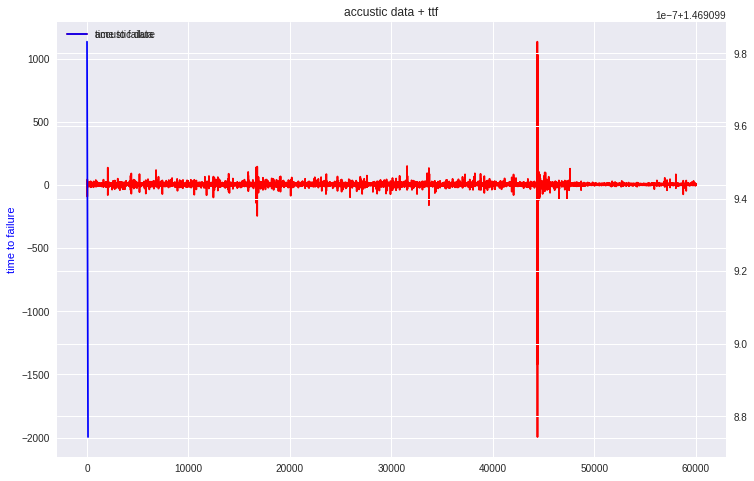

In [27]:
#visualise 1% of the data,first 100 data points
train_ad_sample_df =train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[:100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df,train_ttf_sample_df,title ='accustic data + ttf'):
  fig,ax1 =plt.subplots(figsize =(12,8))
  plt.title(title)
  plt.plot(train_ad_sample_df,color ='r')
  ax1.set_ylabel('acoustic data',color = 'r')
  plt.legend(['accustic data'],loc = (0.01,0.95))
  ax2 = ax1.twinx()
  plt.plot(train_ttf_sample_df,color ='b')
  ax1.set_ylabel('time to failure',color= 'b')
  plt.legend(['time to failure'],loc = (0.01,0.95))
  plt.grid(True)
plot_acc_ttf_data(train_ad_sample_df,train_ttf_sample_df)


In [29]:
#![alttext](https://i.imgur.com/EPAFaPA.png)

/bin/bash: -c: line 0: syntax error near unexpected token `https://i.imgur.com/EPAFaPA.png'
/bin/bash: -c: line 0: `[alttext](https://i.imgur.com/EPAFaPA.png)'


In [0]:
def gen_features(x):
  strain =[]
  strain .append(x.mean())
  strain.append(x.std())
  strain.append(x.min())
  strain.append(x.max())
  strain.append(x.kurtosis())
  strain.append(x.skew())
  strain.append(np.quantile(x,0.01))
  return pd.Series(strain)

In [0]:
train =pd.read_csv('train.csv', iterator =True,chunksize =150_00, dtype={'acoustic_data':np.int16,'time_to_failure':np.float64})
x_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
  ch = gen_features(df['acoustic_data'])
  x_train = x_train.append(ch,ignore_index =True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [37]:
x_train.describe()

,0,1,2,3,4,5,6
count,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000
mean,4.519472,5.697077,-51.937035,62.428190,14.921445,0.054051,-11.819559
std,0.297397,9.094914,97.279562,100.010095,17.177569,0.293193,32.788371
min,3.260800,2.604655,-5515.000000,13.000000,-0.099967,-4.224429,-1726.020000
25%,4.324000,3.547815,-63.000000,30.000000,3.147374,-0.044086,-14.000000
50%,4.521267,4.574561,-36.000000,46.000000,9.057178,0.024943,-8.000000
75%,4.718533,6.305464,-21.000000,74.000000,20.687733,0.128477,-4.000000
max,5.808400,482.621835,-4.000000,5444.000000,368.303958,4.530444,-1.000000


In [38]:
x_train.head()

,0,1,2,3,4,5,6
0,5.083667,9.648327,-98.0,104.0,21.406174,-0.131321,-27.0
1,4.939733,3.933370,-20.0,30.0,4.195286,-0.039745,-5.0
2,4.931600,5.220505,-35.0,40.0,4.026044,0.000936,-10.0
3,4.761800,3.950776,-19.0,34.0,3.339573,0.176724,-6.0
4,5.143667,5.301783,-56.0,52.0,14.269695,-0.055047,-10.0


In [39]:
train_pool =Pool(x_train,y_train)
m = CatBoostRegressor(iterations =15000,loss_function='MAE',boosting_type='Ordered')
m.fit(x_train,y_train,silent = True)
m.best_score_

{'learn': {'MAE': 2.356753981782481}}